# DiscreteDP Example: Bioeconomic Model

** Eiki Takigawa **

*Department of Economics, University of Tokyo*

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section 7.6.6

`Julia` translation of the [python version](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/ddp_ex_MF_7_6_6_py.ipynb)

In [1]:
using QuantEcon
using Plots
pyplot()

Plots.PyPlotBackend()

In [2]:
emax = 8             # Energy carrying capacity
n = emax + 1         # Number of states, 0, ..., emax
m = 3                # Number of areas (actions), 0, ..., m-1
e = [2, 4, 5]        # Energy offerings
p = [1.0, 0.7, 0.8]  # Survival probabilities
q = [0.5, 0.8, 0.7]  # Success probabilities

T = 10               # Time horizon

# Terminal values
v_term = ones(n)
v_term[1]= 0;

We follow the state-action pairs formulation approach.

In [3]:
L = n * m  # Number of feasible state-action pairs

s_indices = Vector{Int}(L)
for i in 1:n
    s_indices[(i-1) * m + 1 : i * m] = i
end

a_indices = Vector{Int}(L)
for i in 1:n
    a_indices[(i-1) * m + 1 : i * m] = 1:m
end

In [4]:
# Reward vector
R = zeros(L);

In [5]:
# Transition probability array
Q = zeros(L, n)
for (i, s) in enumerate(s_indices)
    k = a_indices[i]
    if s == 1
        Q[i, 1] = 1
    elseif s == 2
        Q[i, minimum([emax+1, s-1+e[k]])] = p[k] * q[k]
        Q[i, 1] = 1 - p[k] * q[k]
    else
        Q[i, minimum([emax+1, s-1+e[k]])] = p[k] * q[k]
        Q[i, s-1] = p[k] * (1 - q[k])
        Q[i, 1] = 1 - p[k]
    end
end

The current version of `DiscreteDP` does not accept $\beta = 1$.  
So I use a value very close to 1.

In [6]:
# Discount factor
beta = 0.99999999;

In [7]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices);

`backward_induction` used in the python version does not exist in `QuantEcon.jl`.  
So I simply repeat `bellman_operator`.

In [8]:
vs = Matrix(T+1, n)    
vs[T+1, :] = v_term
for t in T+1:-1:2
    vs[t-1, :] = bellman_operator(ddp, vs[t, :])
end


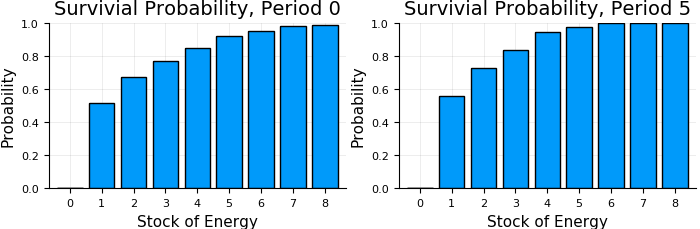

In [9]:
p1 = bar(0:8, vs[1, :], xlabel="Stock of Energy", xticks=0:1:8,
         ylabel="Probability", yticks=0:0.2:1, ylims=(0,1), label="", 
         title="Survivial Probability, Period 0", )
p2 = bar(0:8, vs[6, :], xlabel="Stock of Energy", xticks=0:1:8,
         ylabel="Probability", yticks=0:0.2:1, ylims=(0,1), label="",
         title="Survivial Probability, Period 5", )
plot(p1, p2, layout=(1,2), size=(700,230))